In [36]:
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [37]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 (보기 좋게)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [38]:
# ====== 기본 정리 ======
waterDF = waterDF.dropna(subset=['일자']).sort_values('일자').copy()

# 연/월/계절/로그 변수
waterDF['연도'] = waterDF['일자'].dt.year
waterDF['월'] = waterDF['일자'].dt.month
waterDF['계절구분'] = np.where(waterDF['월'].isin([6,7,8,9]), '여름', '비여름')
waterDF['log_chl'] = np.log1p(waterDF['클로로필-a'])

# 결측률 확인 1회만
display(waterDF.isna().mean().sort_values(ascending=False).head(10))


총질소(T-N)      0.004926
COD           0.004926
클로로필-a        0.004926
유량            0.004926
총유기탄소(TOC)    0.004926
총인(T-P)       0.004926
부유물질          0.004926
log_chl       0.004926
BOD           0.004926
용존산소(DO)      0.004926
dtype: float64

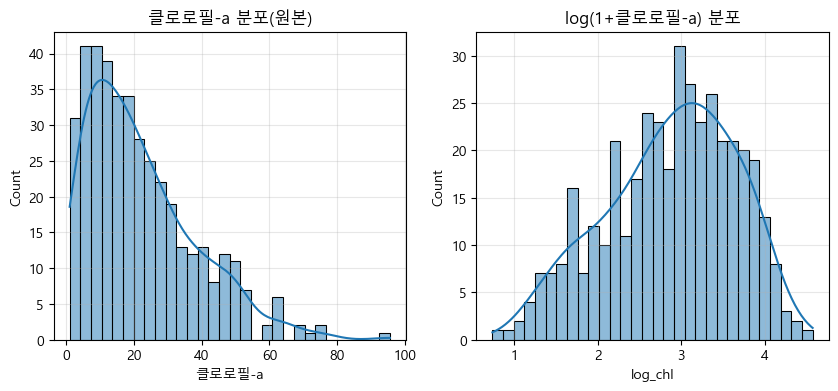

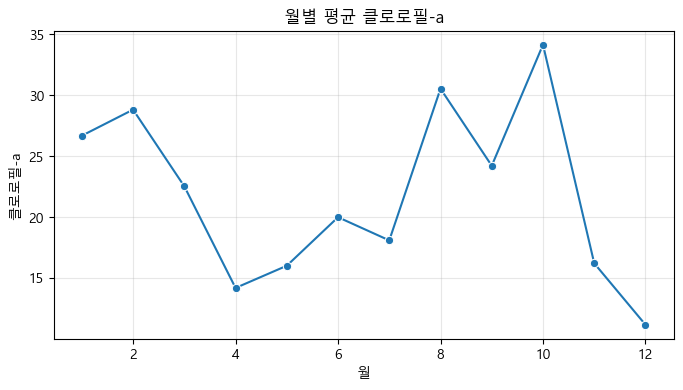

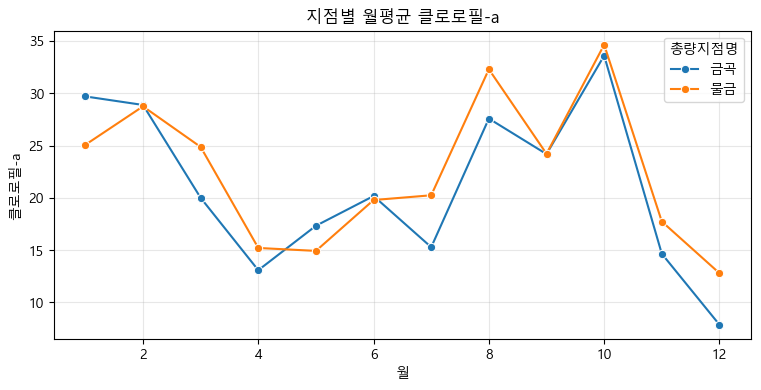

In [39]:
# 1) 클로로필-a 분포(원본/로그)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sb.histplot(waterDF['클로로필-a'], bins=30, kde=True)
plt.title('클로로필-a 분포(원본)'); plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sb.histplot(waterDF['log_chl'], bins=30, kde=True)
plt.title('log(1+클로로필-a) 분포'); plt.grid(alpha=0.3)
plt.show()

# 2) 월별 평균(계절성)
monthly_mean = waterDF.groupby('월')['클로로필-a'].mean().reset_index()
plt.figure(figsize=(8,4))
sb.lineplot(data=monthly_mean, x='월', y='클로로필-a', marker='o')
plt.title('월별 평균 클로로필-a'); plt.grid(alpha=0.3)
plt.show()

# 3) 지점별 월평균(금곡/물금 비교)
site_month = waterDF.groupby(['총량지점명','월'])['클로로필-a'].mean().reset_index()
plt.figure(figsize=(9,4))
sb.lineplot(data=site_month, x='월', y='클로로필-a', hue='총량지점명', marker='o')
plt.title('지점별 월평균 클로로필-a'); plt.grid(alpha=0.3)
plt.show()


C:\Users\Dell3571\AppData\Local\Temp\ipykernel_1656\3983964206.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(


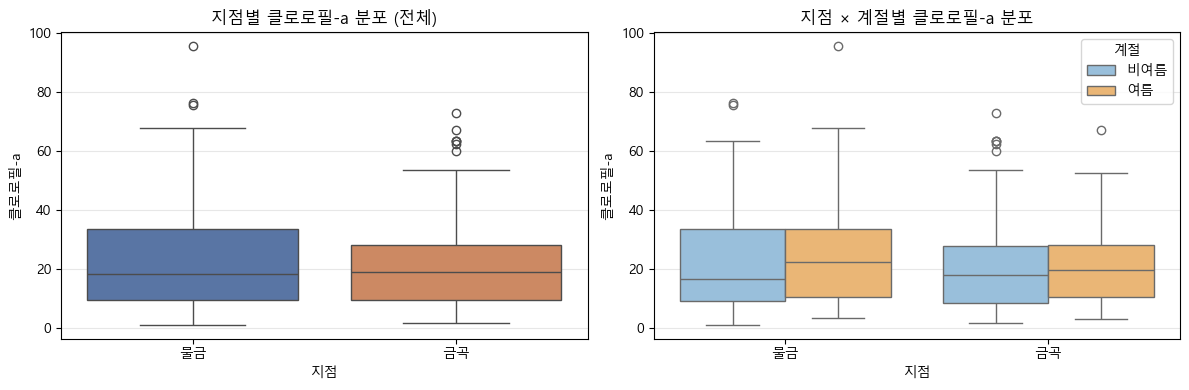

In [40]:
plt.figure(figsize=(12,4))

# 1️⃣ 지점별 클로로필-a 분포 (전체)
plt.subplot(1, 2, 1)
sb.boxplot(
    data=waterDF,
    x='총량지점명',
    y='클로로필-a',
    palette={'물금': '#4C72B0', '금곡': '#DD8452'}
)
plt.title('지점별 클로로필-a 분포 (전체)')
plt.xlabel('지점')
plt.ylabel('클로로필-a')
plt.grid(axis='y', alpha=0.3)

# 2️⃣ 지점 × 계절 박스플롯
plt.subplot(1, 2, 2)
sb.boxplot(
    data=waterDF,
    x='총량지점명',
    y='클로로필-a',
    hue='계절구분',
    palette={'비여름': '#8EC1E6', '여름': '#FDB863'}
)
plt.title('지점 × 계절별 클로로필-a 분포')
plt.xlabel('지점')
plt.ylabel('클로로필-a')
plt.legend(title='계절')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [41]:
# 위험도 기준(고정)
# - 저위험 : 15 미만
# - 중위험 : 15 이상 25 미만
# - 고위험 : 25 이상
bins = [-np.inf, 15, 25, np.inf]
labels = ['저위험','중위험','고위험']
waterDF['위험도'] = pd.cut(waterDF['클로로필-a'], bins=bins, labels=labels)

print("전체 분포\n", waterDF['위험도'].value_counts().sort_index())
print("\n계절별 분포(%)\n", pd.crosstab(waterDF['계절구분'], waterDF['위험도'], normalize='index')*100)


전체 분포
 위험도
저위험    169
중위험     92
고위험    143
Name: count, dtype: int64

계절별 분포(%)
 위험도         저위험        중위험        고위험
계절구분                                 
비여름   43.560606  23.106061  33.333333
여름    38.571429  22.142857  39.285714


In [42]:
# 모델링 데이터 구성
modelDF = waterDF.dropna(subset=['위험도']).copy()

feature_cols = [
    '총량지점명','월',
    '수온','유량',
    '총질소(T-N)','총인(T-P)',
    'BOD','COD','총유기탄소(TOC)'
]

X = modelDF[feature_cols]
y = modelDF['위험도'].astype(str)

# 시계열 기반 학습 / 검증 분리
test_year = modelDF['연도'].max()  # 최신연도(2025)
train_idx = modelDF['연도'] < test_year
test_idx  = modelDF['연도'] == test_year

# 데이터 분할
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# 분할 결과 검증
print("Train 연도:", sorted(modelDF.loc[train_idx,'연도'].unique()))
print("Test 연도 :", sorted(modelDF.loc[test_idx,'연도'].unique()))
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Test 분포:\n", y_test.value_counts())


Train 연도: [2021, 2022, 2023, 2024]
Test 연도 : [2025]
Train: (341, 9) Test: (63, 9)
Test 분포:
 위험도
저위험    25
고위험    20
중위험    18
Name: count, dtype: int64


In [43]:
num_cols = ['월','수온','유량','총질소(T-N)','총인(T-P)','BOD','COD','총유기탄소(TOC)']
cat_cols = ['총량지점명']

# Logistic Regression 전처리
preprocess_lr = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())]), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# RandomForest 전처리
preprocess_rf = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


[LogisticRegression]
               precision    recall  f1-score   support

         고위험       0.72      0.65      0.68        20
         저위험       0.65      0.68      0.67        25
         중위험       0.42      0.44      0.43        18

    accuracy                           0.60        63
   macro avg       0.60      0.59      0.59        63
weighted avg       0.61      0.60      0.61        63

[[13  1  6]
 [ 3 17  5]
 [ 2  8  8]]


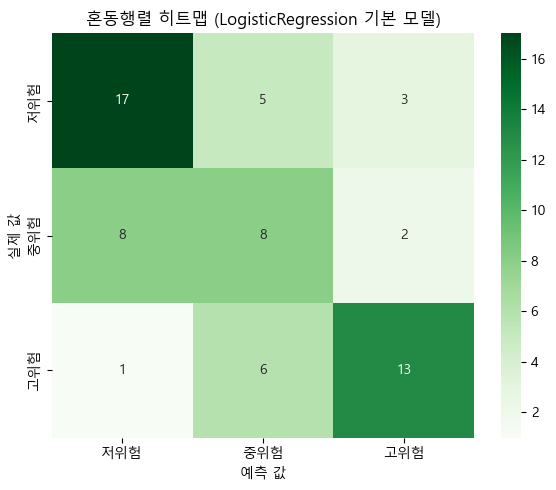

In [ ]:
# LogisticRegression 모델 학습/평가 

lr = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'   # 클래스 불균형 보정
)

lr_pipe = Pipeline([
    ('preprocess', preprocess_lr),  # 수치: 결측+표준화 / 범주: 원핫
    ('model', lr)
])

# 학습 및 예측
lr_pipe.fit(X_train, y_train)
pred_lr = lr_pipe.predict(X_test)

# 성능 출력
print("[LogisticRegression]\n", classification_report(y_test, pred_lr))
print(confusion_matrix(y_test, pred_lr))

# 혼동행렬 히트맵
cm_lr = confusion_matrix(y_test, pred_lr, labels=['저위험','중위험','고위험'])

plt.figure(figsize=(6,5))
sb.heatmap(
    cm_lr,
    annot=True, fmt='d',
    cmap='Greens',
    xticklabels=['저위험','중위험','고위험'],
    yticklabels=['저위험','중위험','고위험']
)
plt.title('혼동행렬 히트맵 (LogisticRegression 기본 모델)')
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.tight_layout()
plt.show()


In [44]:
# RandomForest 모델 구성 및 학습

# RandomForest 전처리 파이프라인
preprocess_rf = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# RandomForest 분류기 설정
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight='balanced_subsample'
)

# 전처리 + 모델을 하나의 파이프라인으로 결합
rf_pipe = Pipeline([('preprocess', preprocess_rf), ('model', rf)])

# 모델 학습
rf_pipe.fit(X_train, y_train)
# 모델 예측 및 성능 평가
pred_rf = rf_pipe.predict(X_test)

# 분류 성능 지표 출력
print("[RandomForest]\n", classification_report(y_test, pred_rf))
# 혼동행렬
print(confusion_matrix(y_test, pred_rf))


[RandomForest]
               precision    recall  f1-score   support

         고위험       0.70      0.80      0.74        20
         저위험       0.65      0.80      0.71        25
         중위험       0.56      0.28      0.37        18

    accuracy                           0.65        63
   macro avg       0.63      0.63      0.61        63
weighted avg       0.64      0.65      0.63        63

[[16  1  3]
 [ 4 20  1]
 [ 3 10  5]]


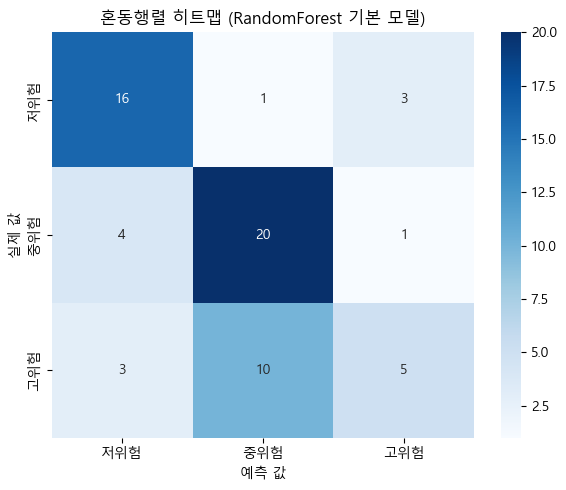

In [ ]:
# RandomForest 기본 모델 히트맵 시각화
c =confusion_matrix(y_test, pred_rf)

plt.figure(figsize=(6,5))
sb.heatmap(
    c,
    annot=True, fmt='d',
    cmap='Blues',
    xticklabels=['저위험', '중위험', '고위험'],
    yticklabels=['저위험', '중위험', '고위험']
)

plt.title('혼동행렬 히트맵 (RandomForest 기본 모델)')
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.tight_layout()
plt.show()

In [46]:
# 고위험 클래스 중심 성능 분석
# 고위험 확률 추출
proba = rf_pipe.predict_proba(X_test)
classes = list(rf_pipe.named_steps['model'].classes_) # 모델이 학습한 클래스 순서 확인
high_idx = classes.index('고위험')
p_high = proba[:, high_idx]

# 이진 분류로 변환
y_true = (y_test == '고위험').astype(int)

# 임계값별 Precision / Recall 계산 함수
def pr_at(th):
    y_pred = (p_high >= th).astype(int)
    tp = ((y_true==1) & (y_pred==1)).sum()
    fp = ((y_true==0) & (y_pred==1)).sum()
    fn = ((y_true==1) & (y_pred==0)).sum()
    precision = tp/(tp+fp) if (tp+fp)>0 else 0
    recall = tp/(tp+fn) if (tp+fn)>0 else 0
    return precision, recall, tp, fp, fn

# 임계값 스윕
thresholds = np.arange(0.10, 0.91, 0.05)
thr_df = pd.DataFrame(
    [[th, *pr_at(th)] for th in thresholds],
    columns=['threshold','precision','recall','TP','FP','FN']
)
thr_df


,threshold,precision,recall,TP,FP,FN
0,0.10,0.395833,0.95,19,29,1
1,0.15,0.441860,0.95,19,24,1
2,0.20,0.529412,0.90,18,16,2
3,0.25,0.562500,0.90,18,14,2
4,0.30,0.642857,0.90,18,10,2
5,0.35,0.666667,0.80,16,8,4
6,0.40,0.652174,0.75,15,8,5
7,0.45,0.789474,0.75,15,4,5
8,0.50,0.777778,0.70,14,4,6
9,0.55,0.714286,0.50,10,4,10


In [ ]:
# 최종 예측 규칙 적용: 고위험 임계값 보정
final_threshold = 0.35  # 고위험으로 판정할 확률 임계값

base_pred = rf_pipe.predict(X_test)  # 기본 3클래스 예측(저/중/고)
y_pred_final = np.where(p_high >= final_threshold, '고위험', base_pred)

# 최종 성능 평가
print(f"[Final RF] threshold={final_threshold}\n", classification_report(y_test, y_pred_final))


[Final RF] threshold=0.35
               precision    recall  f1-score   support

         고위험       0.67      0.80      0.73        20
         저위험       0.65      0.80      0.71        25
         중위험       0.50      0.22      0.31        18

    accuracy                           0.63        63
   macro avg       0.60      0.61      0.58        63
weighted avg       0.61      0.63      0.60        63

[[16  1  3]
 [ 4 20  1]
 [ 4 10  4]]


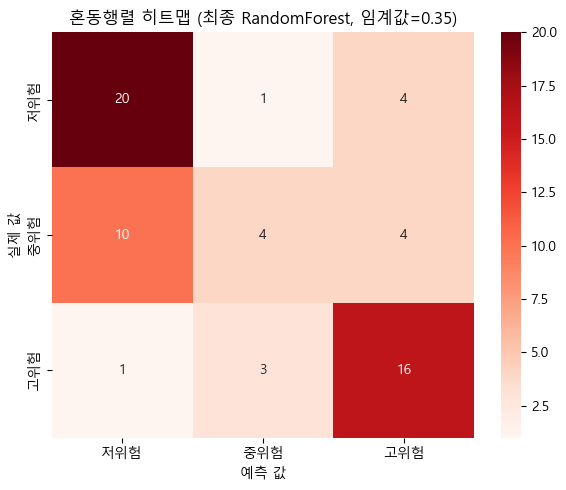

In [48]:
# 혼동행렬 히트맵 시각화

cm = confusion_matrix(y_test, y_pred_final, labels=['저위험','중위험','고위험'])

plt.figure(figsize=(6,5))
sb.heatmap(
    cm,
    annot=True, fmt='d',
    cmap='Reds',
    xticklabels=['저위험','중위험','고위험'],
    yticklabels=['저위험','중위험','고위험']
)
plt.title(f'혼동행렬 히트맵 (최종 RandomForest, 임계값={final_threshold})')
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.tight_layout()
plt.show()